# Example of an extraction using tikhonov regularisation

TODO: Explain waht tikhonov regularisation is and why we use it?

## Imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Import standard packages.
import numpy as np
from astropy.io import fits

# Imports from the extraction.
from SOSS.dms.soss_engine import ExtractionEngine
from SOSS.extract.engine_legacy import ThroughputSOSS, WebbKer

# Imports for plots.
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Matplotlib defaults

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(13,8)) 
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

## Read some ref files

In [4]:
# List of orders to consider in the extraction.
soss_orders = [1, 2]

# WaveMap TODO try using DataModels.
wave_maps = []
wave_maps.append(fits.getdata("../extract/Ref_files/wavelengths_m1.fits"))
wave_maps.append(fits.getdata("../extract/Ref_files/wavelengths_m2.fits"))

# SpecProfile
spat_pros = []
spat_pros.append(fits.getdata("../extract/Ref_files/spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata("../extract/Ref_files/spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

# SpecTrace
thrpt_list = [ThroughputSOSS(order) for order in soss_orders]

# SpecKernel
ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

# Put all inputs from reference files in a list
ref_files = [wave_maps, spat_pros, thrpt_list, ker_list]

## Load simulation

In [5]:
# Import custom function to read toy simulation.
from SOSS.Fake_data.simu_utils import load_simu  

# Load a simulation
simu = load_simu("../Fake_data/phoenix_teff_02300_scale_1.0e+02.fits")

In [6]:
# The science array.
scidata = simu["data"]

# Build an associated error array.
bkgd_noise = 20.  # In counts?
scierr = np.sqrt(scidata + bkgd_noise**2)

## Extraction

### Extraction Parameters
(Example usage with few inputs parameters.)

In [7]:
params = {}

# Wavelength extraction grid oversampling.
params["n_os"] = 5

# Threshold on the spatial profile. 
params["threshold"] = 1e-4

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [8]:
extract = ExtractionEngine(*ref_files, **params)

### Find the best tikhonov factor
This takes some time, so it's better to do it once if the exposures are part of a time series observation, i.e. observations of the same object at similar SNR.

In [9]:
# # Determine which factors to tests.
# factors = np.logspace(-25, -12, 14)

# # Tests all these factors.
# tests = extract.get_tikho_tests(factors, data=scidata, error=scierr)

In [10]:
# # Find the best factor.
# best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)
# print(best_fac)

In [11]:
# # Refine the grid (span 4 orders of magnitude).
# best_fac = np.log10(best_fac)
# factors = np.logspace(best_fac-2, best_fac+2, 20)

# # Test these new factors.
# tests = extract.get_tikho_tests(factors, data=scidata, error=scierr)

In [12]:
# # Find the best factor.
# best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)
# print(best_fac)

In [13]:
best_fac = 6.3580702764558024e-24

### Extract the oversampled spectrum $f_k$
Can be done in a loop for a timeseries and/or iteratively for different estimates of the reference files.

In [14]:
# Extract the spectrum.
f_k = extract.extract(data=scidata, error=scierr, tikhonov=True, factor=best_fac)  

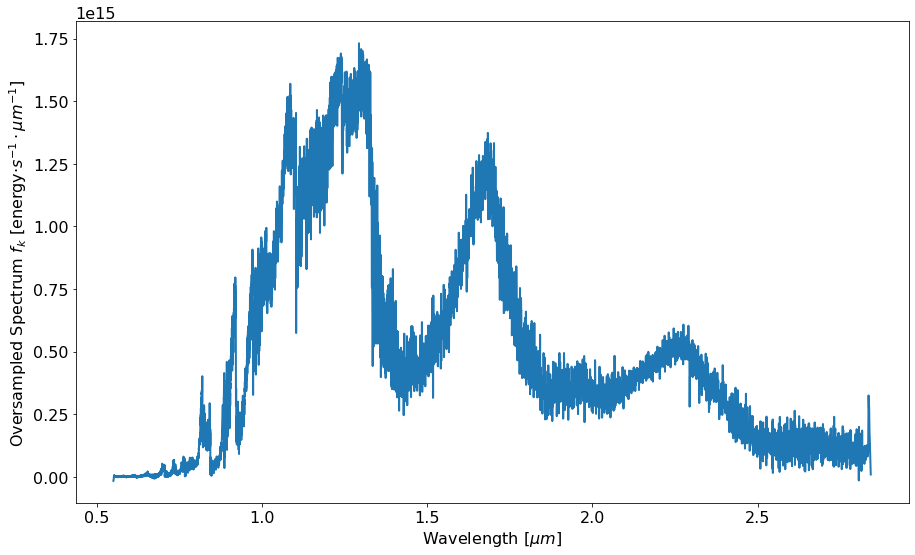

In [15]:
# Plot the extracted spectrum.
plt.plot(extract.wave_grid, f_k)

plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("Oversampled Spectrum $f_k$ [energy$\cdot s^{-1} \cdot \mu m^{-1}$]")
# For now, arbitrairy units, but it should be the flux that hits the detector,
# so energy/time/wavelength

plt.tight_layout()
plt.show()

### Bin to pixel native sampling
To get a result comparable to typical extraction methods, we need to integrate the oversampled spectrum ($f_k$) to a grid representative of the native pixel sampling (for each order). This integration is done according to the equation
\begin{equation}
\mathrm{bin}_{i} = \int_{\lambda_{ni}^-}^{\lambda_{ni}^+} T_n(\lambda)\tilde{f}_n(\lambda)\lambda d\lambda \, ,
\end{equation}
where $n$ is a given order, $T_n$ is the throughput of the order and $\tilde{f}_n$ is the underlying flux convolved to the order $n$ resolution. The result of this integral will be in fake counts (it is not directly the sum of the counts so that's why I call it fake). 

One could directly extract the integrated flux by setting the throughput to $T_n(\lambda) = 1$ (see second example). The result would then be in flux units instead of counts.

#### Bin in counts

In [16]:
# Save the output in a list for different orders.

flux_bin = []  # Integrated flux.
wave_bin = []  # Wavelength grid.

for i_ord in range(extract.n_orders):
    
    # Integrate.
    wave_bin_, flux_bin_ = extract.bin_to_pixel(spectrum=f_k, i_order=i_ord)
    
    # Save.
    wave_bin.append(wave_bin_)
    flux_bin.append(flux_bin_)

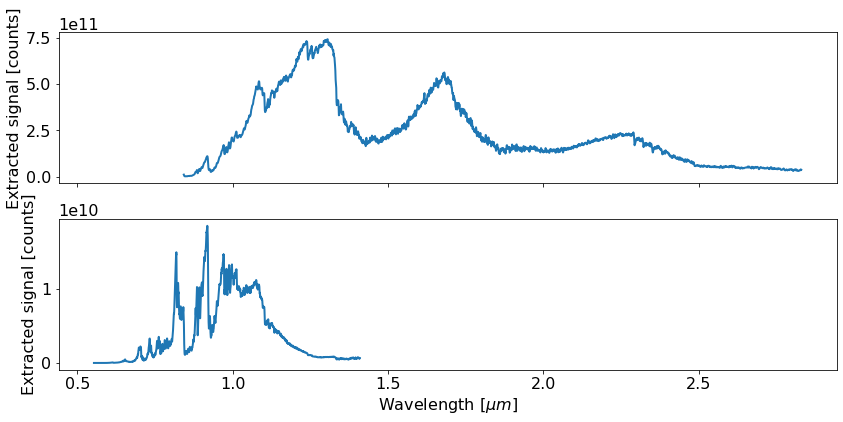

In [17]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

for i_ord in range(extract.n_orders):
    
    label = extract.orders[i_ord]
    ax[i_ord].plot(wave_bin[i_ord], flux_bin[i_ord], label=label)
    
ax[0].set_ylabel("Extracted signal [counts]")
    
ax[1].set_xlabel("Wavelength [$\mu m$]")
ax[1].set_ylabel("Extracted signal [counts]")

plt.tight_layout()
plt.show()

#### Bin in flux units

In [18]:
# Set throughput to 1
def throughput(x):
    return np.ones_like(x)

flux_bin = []  # Integrated flux.
wave_bin = []  # Wavelength grid.

for i_ord in range(extract.n_orders):
    
    # Integrate.
    wave_bin_, flux_bin_ = extract.bin_to_pixel(spectrum=f_k, i_order=i_ord, throughput=throughput)
    
    # Save.
    wave_bin.append(wave_bin_)
    flux_bin.append(flux_bin_)

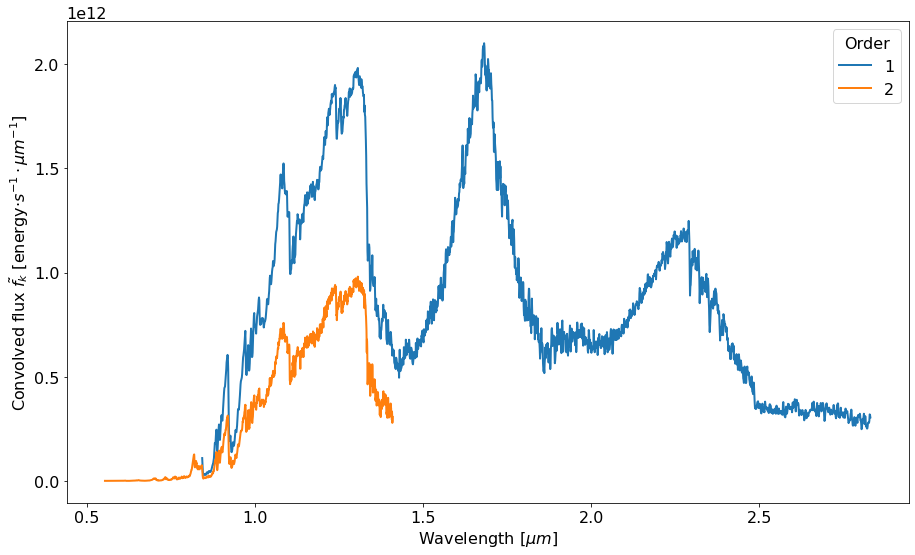

In [19]:
for i_ord in range(extract.n_orders):
    
    label = extract.orders[i_ord]
    plt.plot(wave_bin[i_ord], flux_bin[i_ord], label=label)
    
plt.ylabel(r"Convolved flux $\tilde{f_k}$ [energy$\cdot s^{-1} \cdot \mu m^{-1}$]")  
plt.xlabel("Wavelength [$\mu m$]")

plt.tight_layout()
plt.legend(title="Order")
plt.show()

## Quality estimate

### Rebuild the detector

In [20]:
model_image = extract.rebuild(f_k)

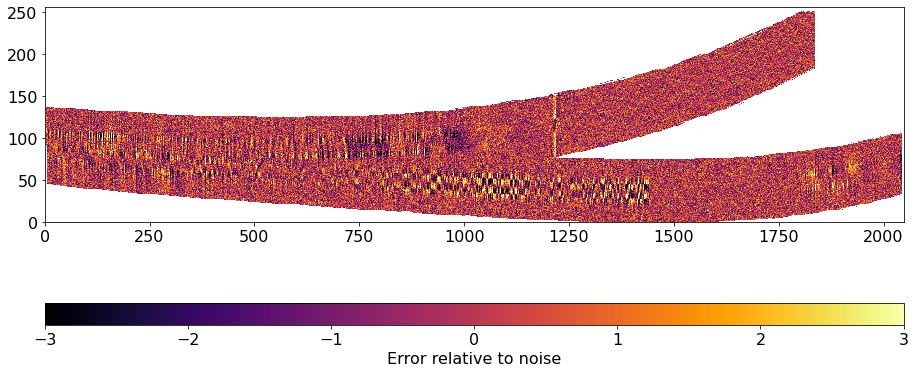

In [21]:
plt.subplot(111, aspect=2)

plt.pcolormesh((model_image - scidata)/scierr, vmin=-3, vmax=3)

plt.colorbar(label="Error relative to noise", orientation='horizontal', aspect=40)

plt.tight_layout()
plt.show()

We can see that we are very close to the photon noise limit in this case. There are some small structures in the 2nd order in the overlap region, but the extracted spectrum is dominated by the 1st order in this wavelength region anyway, due to the higher throughput.